# Unsupervised ML Assignment_Healthcare --Yidan Li yl4357

## Table of Content:
* [1.Updated Feature Engineering](#1)
 * [Feature 1-3 Group by DRG and State](#1.1)
 * [Feature 4-6 Group by DRG and Region](#1.2)
 * [Feature 7-9 Group by DRG and Scale](#1.3)
* [2.Unsupervised Models](#2)
 * [KNN](#2.1)
 * [PCA](#2.2)
 * [KNN and PCA result comparison and combination](#2.3)
 * [Final Result Visualization](#2.4)
 * [Which hospitals can be identified as potential fraud?](#2.5)

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
df=pd.read_csv('/Users/liyidan/Desktop/Anomaly Detection/4. healthcare/inpatientCharges.csv')
print(df.head(3))
print(df.dtypes)

                             DRG Definition  Provider Id  \
0  039 - EXTRACRANIAL PROCEDURES W/O CC/MCC        10001   
1  039 - EXTRACRANIAL PROCEDURES W/O CC/MCC        10005   
2  039 - EXTRACRANIAL PROCEDURES W/O CC/MCC        10006   

                      Provider Name     Provider Street Address Provider City  \
0  SOUTHEAST ALABAMA MEDICAL CENTER      1108 ROSS CLARK CIRCLE        DOTHAN   
1     MARSHALL MEDICAL CENTER SOUTH  2505 U S HIGHWAY 431 NORTH          BOAZ   
2    ELIZA COFFEE MEMORIAL HOSPITAL          205 MARENGO STREET      FLORENCE   

  Provider State  Provider Zip Code Hospital Referral Region Description  \
0             AL              36301                          AL - Dothan   
1             AL              35957                      AL - Birmingham   
2             AL              35631                      AL - Birmingham   

    Total Discharges   Average Covered Charges   Average Total Payments   \
0                  91               $32,963.07       

Variables Definitions:

DRG: Classification system that groups similar clinical conditions (diagnoses) and the procedures furnished by the hospital during the stay.

Total Discharges: The number of discharges billed by all providers for inpatient hospital services.

Average Covered Charges: The average charge of all provider's services covered by Medicare for discharges in the DRG. These will vary from hospital to hospital because of differences in hospital charge structures. (This means that Average Covered Charges is not very helpful for detecting fraud considering the inconsistency across hospitals.)

Average Total Payments: The average total payments to all providers for the DRG including the MS-DRG amount, teaching,  disproportionate share, capital, and outlier payments for all cases. Also included in average total payments are co-payment and deductible amounts that the patient is responsible for and any additional payments by third parties for coordination of benefits.

Average Medicare Payments: The average amount that Medicare pays to the provider for Medicare's share of the MS-DRG. Medicare payment amounts include the MS-DRG amount, teaching,  disproportionate share, capital, and outlier payments for all cases. Medicare payments DO NOT include beneficiary co-payments and deductible amounts nor any additional payments from third parties for coordination of benefits.

In [3]:
#rename the columns
df.columns = ['DRG', 'ID','Name','Street_Adress','City','State','Zipcode','Region',
              'Total_Discharges','Average_Covered_Charges','Average_Total_Payments','Average_Medicare_Payments']

In [4]:
#convert currency to float
df[df.columns[9:]] = df[df.columns[9:]].replace('[\$,]', '', regex=True).astype(float)

### Updated Feature Engineering <a class="anchor" id="1"></a>

#### Feature 1-3 Group by DRG and State <a class="anchor" id="1.1"></a>

#### Feature 1: Average_Total_Payments_DRG_State_Ratio: The average total payments divided by the median average total payments of the same DRG and State.

In [5]:
average_total_payments_drg_state=df.groupby(['DRG','State']).Average_Total_Payments.median().reset_index()
print(average_total_payments_drg_state.head())

                                        DRG State  Average_Total_Payments
0  039 - EXTRACRANIAL PROCEDURES W/O CC/MCC    AK                 8401.95
1  039 - EXTRACRANIAL PROCEDURES W/O CC/MCC    AL                 5658.33
2  039 - EXTRACRANIAL PROCEDURES W/O CC/MCC    AR                 5890.00
3  039 - EXTRACRANIAL PROCEDURES W/O CC/MCC    AZ                 6959.89
4  039 - EXTRACRANIAL PROCEDURES W/O CC/MCC    CA                 7863.14


In [6]:
df1=pd.merge(df,average_total_payments_drg_state,how='left',on=['DRG','State'])
df1=df1.rename(columns={'Average_Total_Payments_x':'Average_Total_Payments',"Average_Total_Payments_y":"Average_Total_Payments_DRG_State"})
df1.head(3)

,DRG,ID,Name,Street_Adress,City,State,Zipcode,Region,Total_Discharges,Average_Covered_Charges,Average_Total_Payments,Average_Medicare_Payments,Average_Total_Payments_DRG_State
0,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,AL - Dothan,91,32963.07,5777.24,4763.73,5658.33
1,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10005,MARSHALL MEDICAL CENTER SOUTH,2505 U S HIGHWAY 431 NORTH,BOAZ,AL,35957,AL - Birmingham,14,15131.85,5787.57,4976.71,5658.33
2,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10006,ELIZA COFFEE MEMORIAL HOSPITAL,205 MARENGO STREET,FLORENCE,AL,35631,AL - Birmingham,24,37560.37,5434.95,4453.79,5658.33


In [7]:
#add ratio
df1['Average_Total_Payments_DRG_State_Ratio']=df1['Average_Total_Payments']/df1['Average_Total_Payments_DRG_State']
df1=df1.drop(columns=['Average_Total_Payments_DRG_State'])
df1.head(3)

,DRG,ID,Name,Street_Adress,City,State,Zipcode,Region,Total_Discharges,Average_Covered_Charges,Average_Total_Payments,Average_Medicare_Payments,Average_Total_Payments_DRG_State_Ratio
0,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,AL - Dothan,91,32963.07,5777.24,4763.73,1.021015
1,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10005,MARSHALL MEDICAL CENTER SOUTH,2505 U S HIGHWAY 431 NORTH,BOAZ,AL,35957,AL - Birmingham,14,15131.85,5787.57,4976.71,1.022841
2,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10006,ELIZA COFFEE MEMORIAL HOSPITAL,205 MARENGO STREET,FLORENCE,AL,35631,AL - Birmingham,24,37560.37,5434.95,4453.79,0.960522


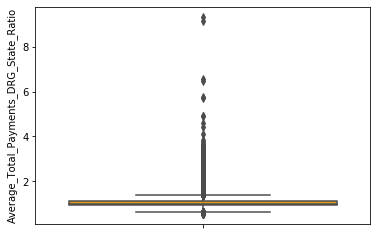

In [19]:
# Distribution of Average_Total_Payments_DRG_State_Ratio
sns.boxplot(y="Average_Total_Payments_DRG_State_Ratio", data=df1,color='orange')
plt.show()

Feature 1 shows the average total payments at a certain DRG of a certain hospital compared with the median level of the average total payment at the same DRG and State. If the ratio is too high compared with 1, there's a possibility that this hopital is overcharging. As shown in the above boxplot, there are outliers (certain DRG in certain hospital) that have average total payments more than 3 times of the median of that DRG in that State, these could potentially be fraud cases.

#### Feature 2: Median_Medicare_Payments_DRG_State_Ratio: The avergae medicare payments divided by the median average medicare payments of the same DRG and State.

In [9]:
average_medicare_payments_drg_state=df.groupby(['DRG','State']).Average_Medicare_Payments.median().reset_index()
print(average_medicare_payments_drg_state.head())

                                        DRG State  Average_Medicare_Payments
0  039 - EXTRACRANIAL PROCEDURES W/O CC/MCC    AK                   6413.780
1  039 - EXTRACRANIAL PROCEDURES W/O CC/MCC    AL                   4471.680
2  039 - EXTRACRANIAL PROCEDURES W/O CC/MCC    AR                   4607.400
3  039 - EXTRACRANIAL PROCEDURES W/O CC/MCC    AZ                   5669.805
4  039 - EXTRACRANIAL PROCEDURES W/O CC/MCC    CA                   6639.330


In [10]:
df2=pd.merge(df1,average_medicare_payments_drg_state,how='left',on=['DRG','State'])
df2=df2.rename(columns={'Average_Medicare_Payments_x':'Average_Medicare_Payments',"Average_Medicare_Payments_y":"Average_Medicare_Payments_DRG_State"})
df2.head(3)

,DRG,ID,Name,Street_Adress,City,State,Zipcode,Region,Total_Discharges,Average_Covered_Charges,Average_Total_Payments,Average_Medicare_Payments,Average_Total_Payments_DRG_State_Ratio,Average_Medicare_Payments_DRG_State
0,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,AL - Dothan,91,32963.07,5777.24,4763.73,1.021015,4471.68
1,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10005,MARSHALL MEDICAL CENTER SOUTH,2505 U S HIGHWAY 431 NORTH,BOAZ,AL,35957,AL - Birmingham,14,15131.85,5787.57,4976.71,1.022841,4471.68
2,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10006,ELIZA COFFEE MEMORIAL HOSPITAL,205 MARENGO STREET,FLORENCE,AL,35631,AL - Birmingham,24,37560.37,5434.95,4453.79,0.960522,4471.68


In [11]:
#add ratio
df2['Average_Medicare_Payments_DRG_State_Ratio']=df2['Average_Medicare_Payments']/df2['Average_Medicare_Payments_DRG_State']
df2=df2.drop(columns=['Average_Medicare_Payments_DRG_State'])
df2.head(3)

,DRG,ID,Name,Street_Adress,City,State,Zipcode,Region,Total_Discharges,Average_Covered_Charges,Average_Total_Payments,Average_Medicare_Payments,Average_Total_Payments_DRG_State_Ratio,Average_Medicare_Payments_DRG_State_Ratio
0,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,AL - Dothan,91,32963.07,5777.24,4763.73,1.021015,1.065311
1,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10005,MARSHALL MEDICAL CENTER SOUTH,2505 U S HIGHWAY 431 NORTH,BOAZ,AL,35957,AL - Birmingham,14,15131.85,5787.57,4976.71,1.022841,1.112940
2,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10006,ELIZA COFFEE MEMORIAL HOSPITAL,205 MARENGO STREET,FLORENCE,AL,35631,AL - Birmingham,24,37560.37,5434.95,4453.79,0.960522,0.995999


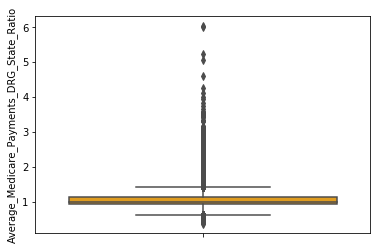

In [18]:
# Distribution of Average_Medicare_Payments_DRG_State_Ratio
sns.boxplot(y="Average_Medicare_Payments_DRG_State_Ratio", data=df2,color='orange')
plt.show()

Feature 2 shows the average medicare payments at a certain DRG of a certain hospital compared with the median level of the average medicare payment at the same DRG and State. If the ratio is too high compare with 1, there's a possibility that this hopital is overcharging. As shown in the above boxplot, there are outliers (certain DRG in certain hospital) that have average medicare payments more than 3 times of the average of that DRG in that State, these could potentially be fraud cases. Notice that although the average medicare payment is highly correlated with average total payment and there's already feature 1 capturing average total payment, feature 2 is still important as there are still many observations that are outside the linear regession line of the 2 variables and there could be observations with relatively low average total payments ratio but hight average medicare payments ratio and we don't want to miss these outliers.

#### Feature 3: Medicare Covered Ratio, the percentage of total payments covered by medicare compared to the median level of the same DRG and same State

In [30]:
df3=df2.copy()
df3['Medicare_Covered_Ratio']=round(df3['Average_Medicare_Payments']/df3['Average_Total_Payments'],2)
df3.head()

,DRG,ID,Name,Street_Adress,City,State,Zipcode,Region,Total_Discharges,Average_Covered_Charges,Average_Total_Payments,Average_Medicare_Payments,Average_Total_Payments_DRG_State_Ratio,Average_Medicare_Payments_DRG_State_Ratio,Medicare_Covered_Ratio
0,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,AL - Dothan,91,32963.07,5777.24,4763.73,1.021015,1.065311,0.82
1,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10005,MARSHALL MEDICAL CENTER SOUTH,2505 U S HIGHWAY 431 NORTH,BOAZ,AL,35957,AL - Birmingham,14,15131.85,5787.57,4976.71,1.022841,1.112940,0.86
2,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10006,ELIZA COFFEE MEMORIAL HOSPITAL,205 MARENGO STREET,FLORENCE,AL,35631,AL - Birmingham,24,37560.37,5434.95,4453.79,0.960522,0.995999,0.82
3,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10011,ST VINCENT'S EAST,50 MEDICAL PARK EAST DRIVE,BIRMINGHAM,AL,35235,AL - Birmingham,25,13998.28,5417.56,4129.16,0.957449,0.923402,0.76
4,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10016,SHELBY BAPTIST MEDICAL CENTER,1000 FIRST STREET NORTH,ALABASTER,AL,35007,AL - Birmingham,18,31633.27,5658.33,4851.44,1.000000,1.084926,0.86


In [31]:
medicare_covered_drg_state=df3.groupby(['DRG','State']).Medicare_Covered_Ratio.median().reset_index()
print(medicare_covered_drg_state.head())

                                        DRG State  Medicare_Covered_Ratio
0  039 - EXTRACRANIAL PROCEDURES W/O CC/MCC    AK                    0.76
1  039 - EXTRACRANIAL PROCEDURES W/O CC/MCC    AL                    0.82
2  039 - EXTRACRANIAL PROCEDURES W/O CC/MCC    AR                    0.81
3  039 - EXTRACRANIAL PROCEDURES W/O CC/MCC    AZ                    0.84
4  039 - EXTRACRANIAL PROCEDURES W/O CC/MCC    CA                    0.86


In [32]:
df3=pd.merge(df3,medicare_covered_drg_state,how='left',on=['DRG','State'])
df3=df3.rename(columns={'Medicare_Covered_Ratio_x':'Medicare_Covered_Ratio',"Medicare_Covered_Ratio_y":"Medicare_Covered_DRG_State"})
df3.head(3)

,DRG,ID,Name,Street_Adress,City,State,Zipcode,Region,Total_Discharges,Average_Covered_Charges,Average_Total_Payments,Average_Medicare_Payments,Average_Total_Payments_DRG_State_Ratio,Average_Medicare_Payments_DRG_State_Ratio,Medicare_Covered_Ratio,Medicare_Covered_DRG_State
0,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,AL - Dothan,91,32963.07,5777.24,4763.73,1.021015,1.065311,0.82,0.82
1,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10005,MARSHALL MEDICAL CENTER SOUTH,2505 U S HIGHWAY 431 NORTH,BOAZ,AL,35957,AL - Birmingham,14,15131.85,5787.57,4976.71,1.022841,1.112940,0.86,0.82
2,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10006,ELIZA COFFEE MEMORIAL HOSPITAL,205 MARENGO STREET,FLORENCE,AL,35631,AL - Birmingham,24,37560.37,5434.95,4453.79,0.960522,0.995999,0.82,0.82


In [33]:
#add ratio
df3['Medicare_Covered_DRG_State_Ratio']=df3['Medicare_Covered_Ratio']/df3['Medicare_Covered_DRG_State']
df3=df3.drop(columns=['Medicare_Covered_Ratio','Medicare_Covered_DRG_State'])
df3.head(3)

,DRG,ID,Name,Street_Adress,City,State,Zipcode,Region,Total_Discharges,Average_Covered_Charges,Average_Total_Payments,Average_Medicare_Payments,Average_Total_Payments_DRG_State_Ratio,Average_Medicare_Payments_DRG_State_Ratio,Medicare_Covered_DRG_State_Ratio
0,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,AL - Dothan,91,32963.07,5777.24,4763.73,1.021015,1.065311,1.00000
1,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10005,MARSHALL MEDICAL CENTER SOUTH,2505 U S HIGHWAY 431 NORTH,BOAZ,AL,35957,AL - Birmingham,14,15131.85,5787.57,4976.71,1.022841,1.112940,1.04878
2,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10006,ELIZA COFFEE MEMORIAL HOSPITAL,205 MARENGO STREET,FLORENCE,AL,35631,AL - Birmingham,24,37560.37,5434.95,4453.79,0.960522,0.995999,1.00000


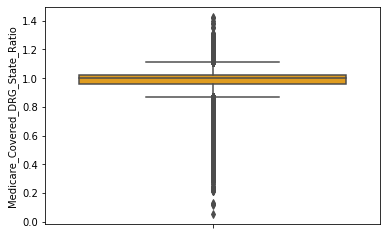

In [35]:
# Distribution of Medicare_Covered_DRG_State_Ratio
sns.boxplot(y="Medicare_Covered_DRG_State_Ratio", data=df3,color='orange')
plt.show()

Feature 3 shows the percentage of total payments covered by medicare divided by the median level of the same DRG and State. This can help detect fraud because when the payments are largely covered by medicare, the patients care less about the price they need to pay and will be more willing to accept more expensive treatments, which gives opportunities to potential fraud. As shown in the above boxplot, there are observations 1.4 times of the median level, which means the patients pay less, this could potentially give both physicians and patients more incentive to conduct fraud.

#### Feature 4-6 Group by DRG and Region <a class="anchor" id="1.2"></a>

#### Feature 4: Average_Total_Payments_DRG_Region_Ratio: The average total payments divided by the median average total payments of the same DRG and region.

In [36]:
average_total_payments_drg_region=df3.groupby(['DRG','Region']).Average_Total_Payments.median().reset_index()
print(average_total_payments_drg_region.head())

                                        DRG           Region  \
0  039 - EXTRACRANIAL PROCEDURES W/O CC/MCC   AK - Anchorage   
1  039 - EXTRACRANIAL PROCEDURES W/O CC/MCC  AL - Birmingham   
2  039 - EXTRACRANIAL PROCEDURES W/O CC/MCC      AL - Dothan   
3  039 - EXTRACRANIAL PROCEDURES W/O CC/MCC  AL - Huntsville   
4  039 - EXTRACRANIAL PROCEDURES W/O CC/MCC      AL - Mobile   

   Average_Total_Payments  
0                8401.950  
1                5541.050  
2                5566.760  
3                5894.965  
4                5550.900  


In [37]:
df4=pd.merge(df3,average_total_payments_drg_region,how='left',on=['DRG','Region'])
df4=df4.rename(columns={'Average_Total_Payments_x':'Average_Total_Payments',"Average_Total_Payments_y":"Average_Total_Payments_DRG_Region"})
df4.head(3)

,DRG,ID,Name,Street_Adress,City,State,Zipcode,Region,Total_Discharges,Average_Covered_Charges,Average_Total_Payments,Average_Medicare_Payments,Average_Total_Payments_DRG_State_Ratio,Average_Medicare_Payments_DRG_State_Ratio,Medicare_Covered_DRG_State_Ratio,Average_Total_Payments_DRG_Region
0,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,AL - Dothan,91,32963.07,5777.24,4763.73,1.021015,1.065311,1.00000,5566.76
1,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10005,MARSHALL MEDICAL CENTER SOUTH,2505 U S HIGHWAY 431 NORTH,BOAZ,AL,35957,AL - Birmingham,14,15131.85,5787.57,4976.71,1.022841,1.112940,1.04878,5541.05
2,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10006,ELIZA COFFEE MEMORIAL HOSPITAL,205 MARENGO STREET,FLORENCE,AL,35631,AL - Birmingham,24,37560.37,5434.95,4453.79,0.960522,0.995999,1.00000,5541.05


In [39]:
#add ratio
df4['Average_Total_Payments_DRG_Region_Ratio']=df4['Average_Total_Payments']/df4['Average_Total_Payments_DRG_Region']
df4=df4.drop(columns=['Average_Total_Payments_DRG_Region'])
df4.head(3)

,DRG,ID,Name,Street_Adress,City,State,Zipcode,Region,Total_Discharges,Average_Covered_Charges,Average_Total_Payments,Average_Medicare_Payments,Average_Total_Payments_DRG_State_Ratio,Average_Medicare_Payments_DRG_State_Ratio,Medicare_Covered_DRG_State_Ratio,Average_Total_Payments_DRG_Region_Ratio
0,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,AL - Dothan,91,32963.07,5777.24,4763.73,1.021015,1.065311,1.00000,1.037810
1,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10005,MARSHALL MEDICAL CENTER SOUTH,2505 U S HIGHWAY 431 NORTH,BOAZ,AL,35957,AL - Birmingham,14,15131.85,5787.57,4976.71,1.022841,1.112940,1.04878,1.044490
2,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10006,ELIZA COFFEE MEMORIAL HOSPITAL,205 MARENGO STREET,FLORENCE,AL,35631,AL - Birmingham,24,37560.37,5434.95,4453.79,0.960522,0.995999,1.00000,0.980852


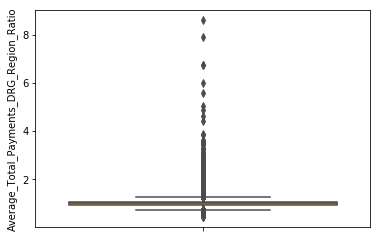

In [40]:
# Distribution of Average_Total_Payments_DRG_Region_Ratio
sns.boxplot(y="Average_Total_Payments_DRG_Region_Ratio", data=df4,color='orange')
plt.show()

Feature 4 shows the average total payments at a certain DRG of a certain hospital compared with the median level of the average total payment at the same DRG and region. If the ratio is too high compared with 1, there's a possibility that this hopital is overcharging. As shown in the above boxplot, there are outliers (certain DRG in certain hospital) that have average total payments more than 3 times of the median of that DRG in that region, these could potentially be fraud cases.

#### Feature 5: Average_Medicare_Payments_DRG_Region_Ratio: The average medicare payments divided by the median average medicare payments of the same DRG and Region.

In [41]:
average_medicare_payments_drg_region=df4.groupby(['DRG','Region']).Average_Medicare_Payments.median().reset_index()
print(average_medicare_payments_drg_region.head())

                                        DRG           Region  \
0  039 - EXTRACRANIAL PROCEDURES W/O CC/MCC   AK - Anchorage   
1  039 - EXTRACRANIAL PROCEDURES W/O CC/MCC  AL - Birmingham   
2  039 - EXTRACRANIAL PROCEDURES W/O CC/MCC      AL - Dothan   
3  039 - EXTRACRANIAL PROCEDURES W/O CC/MCC  AL - Huntsville   
4  039 - EXTRACRANIAL PROCEDURES W/O CC/MCC      AL - Mobile   

   Average_Medicare_Payments  
0                   6413.780  
1                   4471.680  
2                   4585.965  
3                   4868.755  
4                   4219.900  


In [42]:
df5=pd.merge(df4,average_medicare_payments_drg_region,how='left',on=['DRG','Region'])
df5=df5.rename(columns={'Average_Medicare_Payments_x':'Average_Medicare_Payments',"Average_Medicare_Payments_y":"Average_Medicare_Payments_DRG_Region"})
df5.head(3)

,DRG,ID,Name,Street_Adress,City,State,Zipcode,Region,Total_Discharges,Average_Covered_Charges,Average_Total_Payments,Average_Medicare_Payments,Average_Total_Payments_DRG_State_Ratio,Average_Medicare_Payments_DRG_State_Ratio,Medicare_Covered_DRG_State_Ratio,Average_Total_Payments_DRG_Region_Ratio,Average_Medicare_Payments_DRG_Region
0,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,AL - Dothan,91,32963.07,5777.24,4763.73,1.021015,1.065311,1.00000,1.037810,4585.965
1,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10005,MARSHALL MEDICAL CENTER SOUTH,2505 U S HIGHWAY 431 NORTH,BOAZ,AL,35957,AL - Birmingham,14,15131.85,5787.57,4976.71,1.022841,1.112940,1.04878,1.044490,4471.680
2,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10006,ELIZA COFFEE MEMORIAL HOSPITAL,205 MARENGO STREET,FLORENCE,AL,35631,AL - Birmingham,24,37560.37,5434.95,4453.79,0.960522,0.995999,1.00000,0.980852,4471.680


In [43]:
#add ratio
df5['Average_Medicare_Payments_DRG_Region_Ratio']=df5['Average_Medicare_Payments']/df5['Average_Medicare_Payments_DRG_Region']
df5=df5.drop(columns=['Average_Medicare_Payments_DRG_Region'])
df5.head(3)

,DRG,ID,Name,Street_Adress,City,State,Zipcode,Region,Total_Discharges,Average_Covered_Charges,Average_Total_Payments,Average_Medicare_Payments,Average_Total_Payments_DRG_State_Ratio,Average_Medicare_Payments_DRG_State_Ratio,Medicare_Covered_DRG_State_Ratio,Average_Total_Payments_DRG_Region_Ratio,Average_Medicare_Payments_DRG_Region_Ratio
0,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,AL - Dothan,91,32963.07,5777.24,4763.73,1.021015,1.065311,1.00000,1.037810,1.038763
1,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10005,MARSHALL MEDICAL CENTER SOUTH,2505 U S HIGHWAY 431 NORTH,BOAZ,AL,35957,AL - Birmingham,14,15131.85,5787.57,4976.71,1.022841,1.112940,1.04878,1.044490,1.112940
2,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10006,ELIZA COFFEE MEMORIAL HOSPITAL,205 MARENGO STREET,FLORENCE,AL,35631,AL - Birmingham,24,37560.37,5434.95,4453.79,0.960522,0.995999,1.00000,0.980852,0.995999


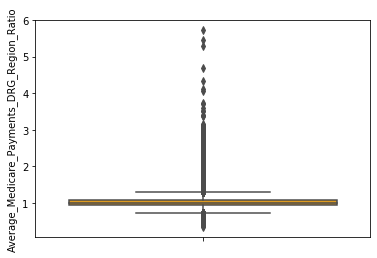

In [44]:
# Distribution of Average_Total_Payments_DRG_Region_Ratio
sns.boxplot(y="Average_Medicare_Payments_DRG_Region_Ratio", data=df5,color='orange')
plt.show()

Feature 5 shows the average medicare payments at a certain DRG of a certain hospital compared with the median level of the average medicare payment at the same DRG and region. If the ratio is too high compared with 1, there's a possibility that this hopital is overcharging. As shown in the above boxplot, there are outliers (certain DRG in certain hospital) that have average medicare payments more than 3 times of the median of that DRG in that region, these could potentially be fraud cases.

#### Feature 6: Medicare Covered Ratio, the percentage of total payments covered by medicare compared to the median level of the same DRG and same Region

In [45]:
df6=df5.copy()
df6['Medicare_Covered_Ratio']=round(df6['Average_Medicare_Payments']/df6['Average_Total_Payments'],2)
df6.head()

,DRG,ID,Name,Street_Adress,City,State,Zipcode,Region,Total_Discharges,Average_Covered_Charges,Average_Total_Payments,Average_Medicare_Payments,Average_Total_Payments_DRG_State_Ratio,Average_Medicare_Payments_DRG_State_Ratio,Medicare_Covered_DRG_State_Ratio,Average_Total_Payments_DRG_Region_Ratio,Average_Medicare_Payments_DRG_Region_Ratio,Medicare_Covered_Ratio
0,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,AL - Dothan,91,32963.07,5777.24,4763.73,1.021015,1.065311,1.000000,1.037810,1.038763,0.82
1,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10005,MARSHALL MEDICAL CENTER SOUTH,2505 U S HIGHWAY 431 NORTH,BOAZ,AL,35957,AL - Birmingham,14,15131.85,5787.57,4976.71,1.022841,1.112940,1.048780,1.044490,1.112940,0.86
2,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10006,ELIZA COFFEE MEMORIAL HOSPITAL,205 MARENGO STREET,FLORENCE,AL,35631,AL - Birmingham,24,37560.37,5434.95,4453.79,0.960522,0.995999,1.000000,0.980852,0.995999,0.82
3,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10011,ST VINCENT'S EAST,50 MEDICAL PARK EAST DRIVE,BIRMINGHAM,AL,35235,AL - Birmingham,25,13998.28,5417.56,4129.16,0.957449,0.923402,0.926829,0.977714,0.923402,0.76
4,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10016,SHELBY BAPTIST MEDICAL CENTER,1000 FIRST STREET NORTH,ALABASTER,AL,35007,AL - Birmingham,18,31633.27,5658.33,4851.44,1.000000,1.084926,1.048780,1.021166,1.084926,0.86


In [46]:
medicare_covered_drg_region=df6.groupby(['DRG','Region']).Medicare_Covered_Ratio.median().reset_index()
print(medicare_covered_drg_region.head())

                                        DRG           Region  \
0  039 - EXTRACRANIAL PROCEDURES W/O CC/MCC   AK - Anchorage   
1  039 - EXTRACRANIAL PROCEDURES W/O CC/MCC  AL - Birmingham   
2  039 - EXTRACRANIAL PROCEDURES W/O CC/MCC      AL - Dothan   
3  039 - EXTRACRANIAL PROCEDURES W/O CC/MCC  AL - Huntsville   
4  039 - EXTRACRANIAL PROCEDURES W/O CC/MCC      AL - Mobile   

   Medicare_Covered_Ratio  
0                   0.760  
1                   0.820  
2                   0.820  
3                   0.825  
4                   0.780  


In [47]:
df6=pd.merge(df6,medicare_covered_drg_region,how='left',on=['DRG','Region'])
df6=df6.rename(columns={'Medicare_Covered_Ratio_x':'Medicare_Covered_Ratio',"Medicare_Covered_Ratio_y":"Medicare_Covered_DRG_Region"})
df6.head(3)

,DRG,ID,Name,Street_Adress,City,State,Zipcode,Region,Total_Discharges,Average_Covered_Charges,Average_Total_Payments,Average_Medicare_Payments,Average_Total_Payments_DRG_State_Ratio,Average_Medicare_Payments_DRG_State_Ratio,Medicare_Covered_DRG_State_Ratio,Average_Total_Payments_DRG_Region_Ratio,Average_Medicare_Payments_DRG_Region_Ratio,Medicare_Covered_Ratio,Medicare_Covered_DRG_Region
0,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,AL - Dothan,91,32963.07,5777.24,4763.73,1.021015,1.065311,1.00000,1.037810,1.038763,0.82,0.82
1,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10005,MARSHALL MEDICAL CENTER SOUTH,2505 U S HIGHWAY 431 NORTH,BOAZ,AL,35957,AL - Birmingham,14,15131.85,5787.57,4976.71,1.022841,1.112940,1.04878,1.044490,1.112940,0.86,0.82
2,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10006,ELIZA COFFEE MEMORIAL HOSPITAL,205 MARENGO STREET,FLORENCE,AL,35631,AL - Birmingham,24,37560.37,5434.95,4453.79,0.960522,0.995999,1.00000,0.980852,0.995999,0.82,0.82


In [49]:
#add ratio
df6['Medicare_Covered_DRG_Region_Ratio']=df6['Medicare_Covered_Ratio']/df6['Medicare_Covered_DRG_Region']
df6=df6.drop(columns=['Medicare_Covered_Ratio','Medicare_Covered_DRG_Region'])
df6.head(3)

,DRG,ID,Name,Street_Adress,City,State,Zipcode,Region,Total_Discharges,Average_Covered_Charges,Average_Total_Payments,Average_Medicare_Payments,Average_Total_Payments_DRG_State_Ratio,Average_Medicare_Payments_DRG_State_Ratio,Medicare_Covered_DRG_State_Ratio,Average_Total_Payments_DRG_Region_Ratio,Average_Medicare_Payments_DRG_Region_Ratio,Medicare_Covered_DRG_Region_Ratio
0,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,AL - Dothan,91,32963.07,5777.24,4763.73,1.021015,1.065311,1.00000,1.037810,1.038763,1.00000
1,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10005,MARSHALL MEDICAL CENTER SOUTH,2505 U S HIGHWAY 431 NORTH,BOAZ,AL,35957,AL - Birmingham,14,15131.85,5787.57,4976.71,1.022841,1.112940,1.04878,1.044490,1.112940,1.04878
2,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10006,ELIZA COFFEE MEMORIAL HOSPITAL,205 MARENGO STREET,FLORENCE,AL,35631,AL - Birmingham,24,37560.37,5434.95,4453.79,0.960522,0.995999,1.00000,0.980852,0.995999,1.00000


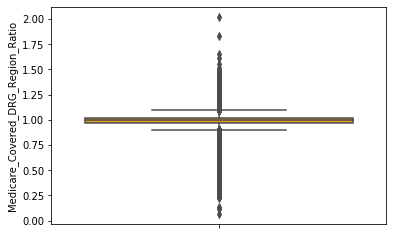

In [51]:
# Distribution of Medicare_Covered_DRG_State_Ratio
sns.boxplot(y="Medicare_Covered_DRG_Region_Ratio",data=df6,color='orange')
plt.show()

Feature 6 shows the percentage of total payments covered by medicare divided by the median level of the same DRG and Region. This can help detect fraud because when the payments are largely covered by medicare, the patients care less about the price they need to pay and will be more willing to accept more expensive treatments, which gives opportunities to potential fraud. As shown in the above boxplot, there are observations more than 1.5 times of the median level, which means the patients pay less, this could potentially give both physicians and patients more incentive to conduct fraud.

#### Feature 7-9 Group by DRG and Scale <a class="anchor" id="1.3"></a>

In [70]:
# define scale (the number of DRGs a provider has)
DRG_number=df6.groupby(['ID']).DRG.count().reset_index()
DRG_number.columns=['ID','DRG_number']

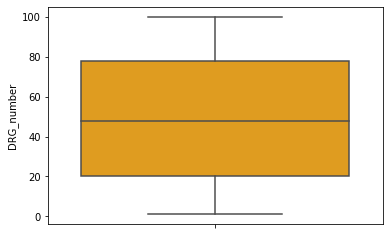

In [71]:
sns.boxplot(y="DRG_number",data=DRG_number,color='orange')
plt.show()

Number of DRGs ranges from 1 to 100, with most between 20 and 80. Define hospital scale as small if less than 20 DRGs, medium if between 20 and 80 DRGs, large if more than 80 DRGs.

In [73]:
import warnings
warnings.filterwarnings("ignore")
DRG_number['Scale']='Medium'
DRG_number['Scale'].loc[DRG_number['DRG_number']<20]='Small'
DRG_number['Scale'].loc[DRG_number['DRG_number']>80]='Large'
DRG_number

,ID,DRG_number,Scale
0,10001,92,Large
1,10005,49,Medium
2,10006,86,Large
3,10007,22,Medium
4,10008,9,Small
...,...,...,...
3332,670072,1,Small
3333,670073,4,Small
3334,670075,6,Small
3335,670076,1,Small


In [69]:
#number of hospitals identified as Small, Medium and Large
DRG_number.Scale.value_counts()

Medium    1786
Small      802
Large      749
Name: Scale, dtype: int64

In [179]:
df7=df6.copy()
df7=pd.merge(df6,DRG_number[['ID','Scale']],how='left',on=['ID'])

Why is Scale a good way to group data by? 
There are different types of hospitals, some are more concentrated on certain DRGs, therefore has less DRGs, and may have better and more expensive treatments offered. While others are more comprehensive with more DRGs available. 

#### Feature 7: Average_Total_Payments_DRG_Scale_Ratio: The average total payments divided by the median average total payments of the same DRG and Scale.

In [79]:
average_total_payments_drg_scale=df7.groupby(['DRG','Scale']).Average_Total_Payments.median().reset_index()
average_total_payments_drg_scale.columns=['DRG','Scale','average_total_payments_drg_scale']
print(average_total_payments_drg_scale.head())

                                                 DRG   Scale  \
0           039 - EXTRACRANIAL PROCEDURES W/O CC/MCC   Large   
1           039 - EXTRACRANIAL PROCEDURES W/O CC/MCC  Medium   
2           039 - EXTRACRANIAL PROCEDURES W/O CC/MCC   Small   
3  057 - DEGENERATIVE NERVOUS SYSTEM DISORDERS W/...   Large   
4  057 - DEGENERATIVE NERVOUS SYSTEM DISORDERS W/...  Medium   

   average_total_payments_drg_scale  
0                          6741.080  
1                          6364.270  
2                          5938.540  
3                          6148.515  
4                          5982.180  


In [80]:
df7=pd.merge(df7,average_total_payments_drg_scale,how='left',on=['DRG','Scale'])
df7.head(3)

,DRG,ID,Name,Street_Adress,City,State,Zipcode,Region,Total_Discharges,Average_Covered_Charges,Average_Total_Payments,Average_Medicare_Payments,Average_Total_Payments_DRG_State_Ratio,Average_Medicare_Payments_DRG_State_Ratio,Medicare_Covered_DRG_State_Ratio,Average_Total_Payments_DRG_Region_Ratio,Average_Medicare_Payments_DRG_Region_Ratio,Medicare_Covered_DRG_Region_Ratio,Scale,average_total_payments_drg_scale
0,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,AL - Dothan,91,32963.07,5777.24,4763.73,1.021015,1.065311,1.00000,1.037810,1.038763,1.00000,Large,6741.08
1,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10005,MARSHALL MEDICAL CENTER SOUTH,2505 U S HIGHWAY 431 NORTH,BOAZ,AL,35957,AL - Birmingham,14,15131.85,5787.57,4976.71,1.022841,1.112940,1.04878,1.044490,1.112940,1.04878,Medium,6364.27
2,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10006,ELIZA COFFEE MEMORIAL HOSPITAL,205 MARENGO STREET,FLORENCE,AL,35631,AL - Birmingham,24,37560.37,5434.95,4453.79,0.960522,0.995999,1.00000,0.980852,0.995999,1.00000,Large,6741.08


In [81]:
#add ratio
df7['Average_Total_Payments_DRG_Scale_Ratio']=df7['Average_Total_Payments']/df7['average_total_payments_drg_scale']
df7=df7.drop(columns=['average_total_payments_drg_scale'])
df7.head(3)

,DRG,ID,Name,Street_Adress,City,State,Zipcode,Region,Total_Discharges,Average_Covered_Charges,Average_Total_Payments,Average_Medicare_Payments,Average_Total_Payments_DRG_State_Ratio,Average_Medicare_Payments_DRG_State_Ratio,Medicare_Covered_DRG_State_Ratio,Average_Total_Payments_DRG_Region_Ratio,Average_Medicare_Payments_DRG_Region_Ratio,Medicare_Covered_DRG_Region_Ratio,Scale,Average_Total_Payments_DRG_Scale_Ratio
0,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,AL - Dothan,91,32963.07,5777.24,4763.73,1.021015,1.065311,1.00000,1.037810,1.038763,1.00000,Large,0.857020
1,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10005,MARSHALL MEDICAL CENTER SOUTH,2505 U S HIGHWAY 431 NORTH,BOAZ,AL,35957,AL - Birmingham,14,15131.85,5787.57,4976.71,1.022841,1.112940,1.04878,1.044490,1.112940,1.04878,Medium,0.909385
2,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10006,ELIZA COFFEE MEMORIAL HOSPITAL,205 MARENGO STREET,FLORENCE,AL,35631,AL - Birmingham,24,37560.37,5434.95,4453.79,0.960522,0.995999,1.00000,0.980852,0.995999,1.00000,Large,0.806243


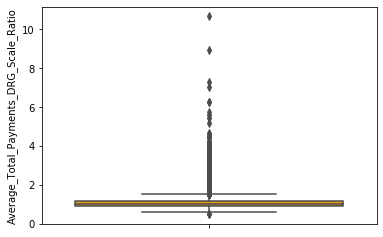

In [97]:
sns.boxplot(y="Average_Total_Payments_DRG_Scale_Ratio",data=df7,color='orange')
plt.show()

Feature 7 shows the average total payments at a certain DRG of a certain hospital compared with the median level of the average total payment at the same DRG and hospital scale. If the ratio is too high compared with 1, there's a possibility that this hopital is overcharging. As shown in the above boxplot, there are outliers (certain DRG in certain hospital) that have average total payments more than 3 times of the median of that DRG for that hospital scale, these could potentially be fraud cases.

#### Feature 8: Average_Medicare_Payments_DRG_Scale_Ratio: The average medicare payments divided by the median average medicare payments of the same DRG and Scale.

In [87]:
average_medicare_payments_drg_scale=df7.groupby(['DRG','Scale']).Average_Medicare_Payments.median().reset_index()
average_medicare_payments_drg_scale.columns=['DRG','Scale','average_medicare_payments_drg_scale']
print(average_medicare_payments_drg_scale.head())

                                                 DRG   Scale  \
0           039 - EXTRACRANIAL PROCEDURES W/O CC/MCC   Large   
1           039 - EXTRACRANIAL PROCEDURES W/O CC/MCC  Medium   
2           039 - EXTRACRANIAL PROCEDURES W/O CC/MCC   Small   
3  057 - DEGENERATIVE NERVOUS SYSTEM DISORDERS W/...   Large   
4  057 - DEGENERATIVE NERVOUS SYSTEM DISORDERS W/...  Medium   

   average_medicare_payments_drg_scale  
0                             5354.190  
1                             5151.635  
2                             4802.040  
3                             5106.660  
4                             5104.120  


In [88]:
df8=pd.merge(df7,average_medicare_payments_drg_scale,how='left',on=['DRG','Scale'])
df8.head(3)

,DRG,ID,Name,Street_Adress,City,State,Zipcode,Region,Total_Discharges,Average_Covered_Charges,...,Average_Medicare_Payments,Average_Total_Payments_DRG_State_Ratio,Average_Medicare_Payments_DRG_State_Ratio,Medicare_Covered_DRG_State_Ratio,Average_Total_Payments_DRG_Region_Ratio,Average_Medicare_Payments_DRG_Region_Ratio,Medicare_Covered_DRG_Region_Ratio,Scale,Average_Total_Payments_DRG_Scale_Ratio,average_medicare_payments_drg_scale
0,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,AL - Dothan,91,32963.07,...,4763.73,1.021015,1.065311,1.00000,1.037810,1.038763,1.00000,Large,0.857020,5354.190
1,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10005,MARSHALL MEDICAL CENTER SOUTH,2505 U S HIGHWAY 431 NORTH,BOAZ,AL,35957,AL - Birmingham,14,15131.85,...,4976.71,1.022841,1.112940,1.04878,1.044490,1.112940,1.04878,Medium,0.909385,5151.635
2,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10006,ELIZA COFFEE MEMORIAL HOSPITAL,205 MARENGO STREET,FLORENCE,AL,35631,AL - Birmingham,24,37560.37,...,4453.79,0.960522,0.995999,1.00000,0.980852,0.995999,1.00000,Large,0.806243,5354.190


In [89]:
#add ratio
df8['Average_Medicare_Payments_DRG_Scale_Ratio']=df8['Average_Medicare_Payments']/df8['average_medicare_payments_drg_scale']
df8=df8.drop(columns=['average_medicare_payments_drg_scale'])
df8.head(3)

,DRG,ID,Name,Street_Adress,City,State,Zipcode,Region,Total_Discharges,Average_Covered_Charges,...,Average_Medicare_Payments,Average_Total_Payments_DRG_State_Ratio,Average_Medicare_Payments_DRG_State_Ratio,Medicare_Covered_DRG_State_Ratio,Average_Total_Payments_DRG_Region_Ratio,Average_Medicare_Payments_DRG_Region_Ratio,Medicare_Covered_DRG_Region_Ratio,Scale,Average_Total_Payments_DRG_Scale_Ratio,Average_Medicare_Payments_DRG_Scale_Ratio
0,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,AL - Dothan,91,32963.07,...,4763.73,1.021015,1.065311,1.00000,1.037810,1.038763,1.00000,Large,0.857020,0.889720
1,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10005,MARSHALL MEDICAL CENTER SOUTH,2505 U S HIGHWAY 431 NORTH,BOAZ,AL,35957,AL - Birmingham,14,15131.85,...,4976.71,1.022841,1.112940,1.04878,1.044490,1.112940,1.04878,Medium,0.909385,0.966045
2,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10006,ELIZA COFFEE MEMORIAL HOSPITAL,205 MARENGO STREET,FLORENCE,AL,35631,AL - Birmingham,24,37560.37,...,4453.79,0.960522,0.995999,1.00000,0.980852,0.995999,1.00000,Large,0.806243,0.831833


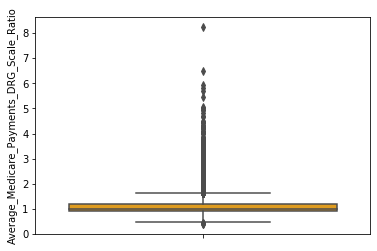

In [96]:
sns.boxplot(y="Average_Medicare_Payments_DRG_Scale_Ratio",data=df8,color='orange')
plt.show()

Feature 8 shows the average medicare payments at a certain DRG of a certain hospital compared with the median level of the average medicare payment at the same DRG and hospital scale. If the ratio is too high compared with 1, there's a possibility that this hopital is overcharging. As shown in the above boxplot, there are outliers (certain DRG in certain hospital) that have average medicare payments more than 3 times of the median of that DRG of that hospital scale, these could potentially be fraud cases.

#### Feature 9: Medicare Covered Ratio, the percentage of total payments covered by medicare compared to the median level of the same DRG and same Scale

In [90]:
df9=df8.copy()
df9['Medicare_Covered_Ratio']=round(df9['Average_Medicare_Payments']/df9['Average_Total_Payments'],2)
df9.head(3)

,DRG,ID,Name,Street_Adress,City,State,Zipcode,Region,Total_Discharges,Average_Covered_Charges,...,Average_Total_Payments_DRG_State_Ratio,Average_Medicare_Payments_DRG_State_Ratio,Medicare_Covered_DRG_State_Ratio,Average_Total_Payments_DRG_Region_Ratio,Average_Medicare_Payments_DRG_Region_Ratio,Medicare_Covered_DRG_Region_Ratio,Scale,Average_Total_Payments_DRG_Scale_Ratio,Average_Medicare_Payments_DRG_Scale_Ratio,Medicare_Covered_Ratio
0,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,AL - Dothan,91,32963.07,...,1.021015,1.065311,1.00000,1.037810,1.038763,1.00000,Large,0.857020,0.889720,0.82
1,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10005,MARSHALL MEDICAL CENTER SOUTH,2505 U S HIGHWAY 431 NORTH,BOAZ,AL,35957,AL - Birmingham,14,15131.85,...,1.022841,1.112940,1.04878,1.044490,1.112940,1.04878,Medium,0.909385,0.966045,0.86
2,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10006,ELIZA COFFEE MEMORIAL HOSPITAL,205 MARENGO STREET,FLORENCE,AL,35631,AL - Birmingham,24,37560.37,...,0.960522,0.995999,1.00000,0.980852,0.995999,1.00000,Large,0.806243,0.831833,0.82


In [92]:
medicare_covered_drg_scale=df9.groupby(['DRG','Scale']).Medicare_Covered_Ratio.median().reset_index()
medicare_covered_drg_scale.columns=['DRG','Scale','medicare_covered_drg_scale']
print(medicare_covered_drg_scale.head())

                                                 DRG   Scale  \
0           039 - EXTRACRANIAL PROCEDURES W/O CC/MCC   Large   
1           039 - EXTRACRANIAL PROCEDURES W/O CC/MCC  Medium   
2           039 - EXTRACRANIAL PROCEDURES W/O CC/MCC   Small   
3  057 - DEGENERATIVE NERVOUS SYSTEM DISORDERS W/...   Large   
4  057 - DEGENERATIVE NERVOUS SYSTEM DISORDERS W/...  Medium   

   medicare_covered_drg_scale  
0                       0.820  
1                       0.830  
2                       0.835  
3                       0.850  
4                       0.860  


In [93]:
df9=pd.merge(df9,medicare_covered_drg_scale,how='left',on=['DRG','Scale'])
df9.head(3)

,DRG,ID,Name,Street_Adress,City,State,Zipcode,Region,Total_Discharges,Average_Covered_Charges,...,Average_Medicare_Payments_DRG_State_Ratio,Medicare_Covered_DRG_State_Ratio,Average_Total_Payments_DRG_Region_Ratio,Average_Medicare_Payments_DRG_Region_Ratio,Medicare_Covered_DRG_Region_Ratio,Scale,Average_Total_Payments_DRG_Scale_Ratio,Average_Medicare_Payments_DRG_Scale_Ratio,Medicare_Covered_Ratio,medicare_covered_drg_scale
0,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,AL - Dothan,91,32963.07,...,1.065311,1.00000,1.037810,1.038763,1.00000,Large,0.857020,0.889720,0.82,0.82
1,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10005,MARSHALL MEDICAL CENTER SOUTH,2505 U S HIGHWAY 431 NORTH,BOAZ,AL,35957,AL - Birmingham,14,15131.85,...,1.112940,1.04878,1.044490,1.112940,1.04878,Medium,0.909385,0.966045,0.86,0.83
2,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10006,ELIZA COFFEE MEMORIAL HOSPITAL,205 MARENGO STREET,FLORENCE,AL,35631,AL - Birmingham,24,37560.37,...,0.995999,1.00000,0.980852,0.995999,1.00000,Large,0.806243,0.831833,0.82,0.82


In [94]:
#add ratio
df9['Medicare_Covered_DRG_Scale_Ratio']=df9['Medicare_Covered_Ratio']/df9['medicare_covered_drg_scale']
df9=df9.drop(columns=['Medicare_Covered_Ratio','medicare_covered_drg_scale'])
df9.head(3)

,DRG,ID,Name,Street_Adress,City,State,Zipcode,Region,Total_Discharges,Average_Covered_Charges,...,Average_Total_Payments_DRG_State_Ratio,Average_Medicare_Payments_DRG_State_Ratio,Medicare_Covered_DRG_State_Ratio,Average_Total_Payments_DRG_Region_Ratio,Average_Medicare_Payments_DRG_Region_Ratio,Medicare_Covered_DRG_Region_Ratio,Scale,Average_Total_Payments_DRG_Scale_Ratio,Average_Medicare_Payments_DRG_Scale_Ratio,Medicare_Covered_DRG_Scale_Ratio
0,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,AL - Dothan,91,32963.07,...,1.021015,1.065311,1.00000,1.037810,1.038763,1.00000,Large,0.857020,0.889720,1.000000
1,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10005,MARSHALL MEDICAL CENTER SOUTH,2505 U S HIGHWAY 431 NORTH,BOAZ,AL,35957,AL - Birmingham,14,15131.85,...,1.022841,1.112940,1.04878,1.044490,1.112940,1.04878,Medium,0.909385,0.966045,1.036145
2,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10006,ELIZA COFFEE MEMORIAL HOSPITAL,205 MARENGO STREET,FLORENCE,AL,35631,AL - Birmingham,24,37560.37,...,0.960522,0.995999,1.00000,0.980852,0.995999,1.00000,Large,0.806243,0.831833,1.000000


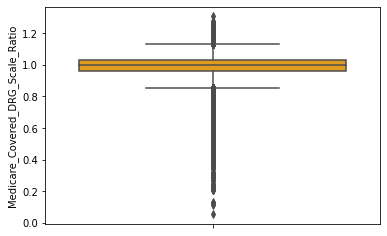

In [95]:
sns.boxplot(y="Medicare_Covered_DRG_Scale_Ratio",data=df9,color='orange')
plt.show()

Feature 9 shows the percentage of total payments covered by medicare divided by the median level of the same DRG and hospital scale. This can help detect fraud because when the payments are largely covered by medicare, the patients care less about the price they need to pay and will be more willing to accept more expensive treatments, which gives opportunities to potential fraud. As shown in the above boxplot, there are observations more than 1.2 times of the median level, which means the patients pay less, this could potentially give both physicians and patients more incentive to conduct fraud.

### Summary of FE
During the above feature engineering, I considered group the data by DRG and State, DRG and region, DRG and hospital scale. The data is compared with the median levels, which can directly reflect outliers. 

In [98]:
df9.columns

Index(['DRG', 'ID', 'Name', 'Street_Adress', 'City', 'State', 'Zipcode',
       'Region', 'Total_Discharges', 'Average_Covered_Charges',
       'Average_Total_Payments', 'Average_Medicare_Payments',
       'Average_Total_Payments_DRG_State_Ratio',
       'Average_Medicare_Payments_DRG_State_Ratio',
       'Medicare_Covered_DRG_State_Ratio',
       'Average_Total_Payments_DRG_Region_Ratio',
       'Average_Medicare_Payments_DRG_Region_Ratio',
       'Medicare_Covered_DRG_Region_Ratio', 'Scale',
       'Average_Total_Payments_DRG_Scale_Ratio',
       'Average_Medicare_Payments_DRG_Scale_Ratio',
       'Medicare_Covered_DRG_Scale_Ratio'],
      dtype='object')

In [108]:
X=df9[['Average_Total_Payments_DRG_State_Ratio',
       'Average_Medicare_Payments_DRG_State_Ratio',
       'Average_Total_Payments_DRG_Region_Ratio',
       'Average_Medicare_Payments_DRG_Region_Ratio',
       'Average_Total_Payments_DRG_Scale_Ratio',
       'Average_Medicare_Payments_DRG_Scale_Ratio']]

In [109]:
# Standardize data
from pyod.utils.utility import standardizer
X_norm=standardizer(X)

### Unsupervised Models <a class="anchor" id="2"></a>

### KNN  <a class="anchor" id="2.1"></a>

What is unsupervised KNN in pyod?
Unsupervised KNN computes the Euclidean distance of a point to its k nearest neighbors and select points that have large distance to other observations. And these points are considered as outliers.

In [110]:
from pyod.models.knn import KNN
from pyod.models.combination import aom, moa, average, maximization

# Test a range of k-neighbors from 10 to 200. There will be 10 k-NN models.
n_clf = 10
k_list = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
# Prepare a data frame to store the model results
scores=np.zeros([X_norm.shape[0],n_clf])
# Modeling
for i in range(n_clf):
    k = k_list[i]
    clf = KNN(n_neighbors=k, method='largest') #use the maximum distance to the k neighbors as the outlier score
    clf.fit(X_norm)
    scores[:, i] = clf.decision_function(X_norm) 
# Normalize the decision score before combination
scores_norm=standardizer(scores)

In [111]:
scores_norm=pd.DataFrame(scores_norm)
scores_norm.to_csv('scores_norm.csv')

In [112]:
# Combination by average to a single column: 
knn_score = average(scores_norm)  #average for each row or each observation

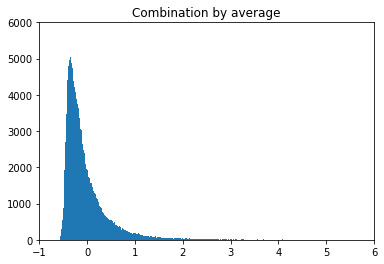

In [117]:
import matplotlib.pyplot as plt
plt.hist(knn_score,bins='auto') # arguments are passed to np.histogram  
plt.title("Combination by average")
plt.xlim(-1, 6) 
plt.ylim(0, 6000) 
plt.show()

In [119]:
knn_result = pd.DataFrame(X)
knn_result['knn_score'] = knn_score
knn_result['knn_cluster'] = np.where(knn_result['knn_score']<0.9, 0, 1)

print(pd.concat([knn_result['knn_cluster'].value_counts(sort=False),knn_result['knn_cluster'].value_counts(normalize=True).mul(100)],
                    axis=1,keys=('counts','percentage')))

   counts  percentage
0  154388   94.678809
1    8677    5.321191


In [120]:
knn_result.groupby('knn_cluster').mean()

,Average_Total_Payments_DRG_State_Ratio,Average_Medicare_Payments_DRG_State_Ratio,Average_Total_Payments_DRG_Region_Ratio,Average_Medicare_Payments_DRG_Region_Ratio,Average_Total_Payments_DRG_Scale_Ratio,Average_Medicare_Payments_DRG_Scale_Ratio,knn_score
knn_cluster,,,,,,,
0,1.024651,1.031815,1.017676,1.021783,1.041636,1.056014,-0.114412
1,1.515044,1.476633,1.368252,1.335846,1.704625,1.693529,2.035708


Cluster 1 has higher ratios in all 6 features compared with cluster 0 and a higher overall average score, which means cluster 1 is far away from the rest of the points. Also, it accounts for 5.35% of all observations, which  is a reasonable size. Therefore, I identify cluster 1 as the anomaly.

In [121]:
knn_final=pd.concat([df,knn_result],axis=1)

In [122]:
knn_final.to_csv('knn_final.csv')

In [124]:
knn_final.head()

,DRG,ID,Name,Street_Adress,City,State,Zipcode,Region,Total_Discharges,Average_Covered_Charges,Average_Total_Payments,Average_Medicare_Payments,Average_Total_Payments_DRG_State_Ratio,Average_Medicare_Payments_DRG_State_Ratio,Average_Total_Payments_DRG_Region_Ratio,Average_Medicare_Payments_DRG_Region_Ratio,Average_Total_Payments_DRG_Scale_Ratio,Average_Medicare_Payments_DRG_Scale_Ratio,knn_score,knn_cluster
0,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,AL - Dothan,91,32963.07,5777.24,4763.73,1.021015,1.065311,1.037810,1.038763,0.857020,0.889720,-0.257222,0
1,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10005,MARSHALL MEDICAL CENTER SOUTH,2505 U S HIGHWAY 431 NORTH,BOAZ,AL,35957,AL - Birmingham,14,15131.85,5787.57,4976.71,1.022841,1.112940,1.044490,1.112940,0.909385,0.966045,-0.251048,0
2,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10006,ELIZA COFFEE MEMORIAL HOSPITAL,205 MARENGO STREET,FLORENCE,AL,35631,AL - Birmingham,24,37560.37,5434.95,4453.79,0.960522,0.995999,0.980852,0.995999,0.806243,0.831833,-0.362469,0
3,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10011,ST VINCENT'S EAST,50 MEDICAL PARK EAST DRIVE,BIRMINGHAM,AL,35235,AL - Birmingham,25,13998.28,5417.56,4129.16,0.957449,0.923402,0.977714,0.923402,0.803664,0.771202,-0.260770,0
4,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10016,SHELBY BAPTIST MEDICAL CENTER,1000 FIRST STREET NORTH,ALABASTER,AL,35007,AL - Birmingham,18,31633.27,5658.33,4851.44,1.000000,1.084926,1.021166,1.084926,0.889078,0.941728,-0.306986,0


### PCA  <a class="anchor" id="2.2"></a>

What is PCA in pyod?
PCA is the process of computing the principal components and find a few principal components that can be defined as directions that maximize the variance of the projected data. In pyod, we preserve all the principal components and use them to calculate the distances between data points. Those data points that are most far away from others will be defined as anomalies.

In [125]:
X=df9[['Average_Total_Payments_DRG_State_Ratio',
       'Average_Medicare_Payments_DRG_State_Ratio',
       'Average_Total_Payments_DRG_Region_Ratio',
       'Average_Medicare_Payments_DRG_Region_Ratio',
       'Average_Total_Payments_DRG_Scale_Ratio',
       'Average_Medicare_Payments_DRG_Scale_Ratio']]

# Standardize data
from pyod.utils.utility import standardizer
X_norm=standardizer(X)

In [129]:
# train PCA detector
from pyod.models.pca import PCA
from pyod.utils.utility import standardizer
clf = PCA()
clf.fit(X_norm)
pca_score = clf.decision_scores_

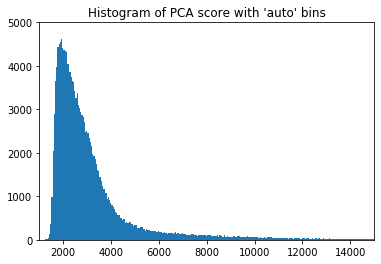

In [133]:
import matplotlib.pyplot as plt
plt.hist(pca_score, bins='auto')  # arguments are passed to np.histogram
plt.title("Histogram of PCA score with 'auto' bins")
plt.xlim(1000, 15000) 
plt.ylim(0, 5000) 
plt.show()

In [143]:
pca_result = pd.DataFrame(X)
pca_result['pca_score'] = pca_score
pca_result['pca_cluster'] = np.where(pca_result['pca_score']<7300, 0, 1)
print(pd.concat([pca_result['pca_cluster'].value_counts(sort=False),pca_result['pca_cluster'].value_counts(normalize=True).mul(100)],
                    axis=1,keys=('counts','percentage')))

   counts  percentage
0  154535   94.768957
1    8530    5.231043


In [144]:
# Now let's show the summary statistics:
pca_result.groupby('pca_cluster').mean()

,Average_Total_Payments_DRG_State_Ratio,Average_Medicare_Payments_DRG_State_Ratio,Average_Total_Payments_DRG_Region_Ratio,Average_Medicare_Payments_DRG_Region_Ratio,Average_Total_Payments_DRG_Scale_Ratio,Average_Medicare_Payments_DRG_Scale_Ratio,pca_score
pca_cluster,,,,,,,
0,1.017735,1.018983,1.011022,1.010940,1.036638,1.044355,2816.680421
1,1.648789,1.716761,1.494848,1.537687,1.806602,1.915741,10718.313502


In [145]:
pca_result.head()

,Average_Total_Payments_DRG_State_Ratio,Average_Medicare_Payments_DRG_State_Ratio,Average_Total_Payments_DRG_Region_Ratio,Average_Medicare_Payments_DRG_Region_Ratio,Average_Total_Payments_DRG_Scale_Ratio,Average_Medicare_Payments_DRG_Scale_Ratio,pca_score,pca_cluster
0,1.021015,1.065311,1.037810,1.038763,0.857020,0.889720,2219.012168,0
1,1.022841,1.112940,1.044490,1.112940,0.909385,0.966045,1977.451092,0
2,0.960522,0.995999,0.980852,0.995999,0.806243,0.831833,2665.748209,0
3,0.957449,0.923402,0.977714,0.923402,0.803664,0.771202,3054.040271,0
4,1.000000,1.084926,1.021166,1.084926,0.889078,0.941728,2025.269024,0


In [146]:
pca_final=pd.concat([df,pca_result],axis=1)
pca_final.head()

,DRG,ID,Name,Street_Adress,City,State,Zipcode,Region,Total_Discharges,Average_Covered_Charges,Average_Total_Payments,Average_Medicare_Payments,Average_Total_Payments_DRG_State_Ratio,Average_Medicare_Payments_DRG_State_Ratio,Average_Total_Payments_DRG_Region_Ratio,Average_Medicare_Payments_DRG_Region_Ratio,Average_Total_Payments_DRG_Scale_Ratio,Average_Medicare_Payments_DRG_Scale_Ratio,pca_score,pca_cluster
0,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,AL - Dothan,91,32963.07,5777.24,4763.73,1.021015,1.065311,1.037810,1.038763,0.857020,0.889720,2219.012168,0
1,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10005,MARSHALL MEDICAL CENTER SOUTH,2505 U S HIGHWAY 431 NORTH,BOAZ,AL,35957,AL - Birmingham,14,15131.85,5787.57,4976.71,1.022841,1.112940,1.044490,1.112940,0.909385,0.966045,1977.451092,0
2,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10006,ELIZA COFFEE MEMORIAL HOSPITAL,205 MARENGO STREET,FLORENCE,AL,35631,AL - Birmingham,24,37560.37,5434.95,4453.79,0.960522,0.995999,0.980852,0.995999,0.806243,0.831833,2665.748209,0
3,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10011,ST VINCENT'S EAST,50 MEDICAL PARK EAST DRIVE,BIRMINGHAM,AL,35235,AL - Birmingham,25,13998.28,5417.56,4129.16,0.957449,0.923402,0.977714,0.923402,0.803664,0.771202,3054.040271,0
4,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10016,SHELBY BAPTIST MEDICAL CENTER,1000 FIRST STREET NORTH,ALABASTER,AL,35007,AL - Birmingham,18,31633.27,5658.33,4851.44,1.000000,1.084926,1.021166,1.084926,0.889078,0.941728,2025.269024,0


### KNN and PCA result comparison  <a class="anchor" id="2.3"></a>

In [147]:
combined_result=pd.concat([knn_final, pca_final[['pca_score','pca_cluster']]], axis=1)

In [148]:
combined_result['compare'] = np.where((combined_result.knn_cluster == combined_result.pca_cluster),1,0)

In [149]:
#get the percentage of observations that are given the same cluster in the 2 methods
percent_same=combined_result['compare'].sum()/combined_result['compare'].count()
percent_same

0.9541593842946064

In [150]:
#get the percentage that are identified as cluster 1 in 2 methods out of the obervations that are identified as cluster 1 at least once
potential_fraud = combined_result[(combined_result['knn_cluster'] == 1)|(combined_result['pca_cluster'] == 1)]
percent_fraud_same=potential_fraud['compare'].sum()/potential_fraud['compare'].count()
percent_fraud_same

0.394295437970991

In [151]:
#get the observations that are identified as fraud by both knn and pca
agreed_fraud=combined_result[(combined_result['knn_cluster'] == 1)&(combined_result['pca_cluster'] == 1)]
#get the percentage of agreed potential fraud among all observations
agreed_fraud_percent=agreed_fraud.shape[0]/combined_result.shape[0]
agreed_fraud_percent

0.029840861006347162

Combining the results of knn and pca methods, I got 2.98% of observations that are considered as cluster 1 by both methods.

In [152]:
combined_result['potential_fraud'] = np.where((combined_result['knn_cluster'] == 1)&(combined_result['pca_cluster'] == 1),1,0)

In [153]:
combined_result.head()

,DRG,ID,Name,Street_Adress,City,State,Zipcode,Region,Total_Discharges,Average_Covered_Charges,...,Average_Total_Payments_DRG_Region_Ratio,Average_Medicare_Payments_DRG_Region_Ratio,Average_Total_Payments_DRG_Scale_Ratio,Average_Medicare_Payments_DRG_Scale_Ratio,knn_score,knn_cluster,pca_score,pca_cluster,compare,potential_fraud
0,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,AL - Dothan,91,32963.07,...,1.037810,1.038763,0.857020,0.889720,-0.257222,0,2219.012168,0,1,0
1,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10005,MARSHALL MEDICAL CENTER SOUTH,2505 U S HIGHWAY 431 NORTH,BOAZ,AL,35957,AL - Birmingham,14,15131.85,...,1.044490,1.112940,0.909385,0.966045,-0.251048,0,1977.451092,0,1,0
2,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10006,ELIZA COFFEE MEMORIAL HOSPITAL,205 MARENGO STREET,FLORENCE,AL,35631,AL - Birmingham,24,37560.37,...,0.980852,0.995999,0.806243,0.831833,-0.362469,0,2665.748209,0,1,0
3,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10011,ST VINCENT'S EAST,50 MEDICAL PARK EAST DRIVE,BIRMINGHAM,AL,35235,AL - Birmingham,25,13998.28,...,0.977714,0.923402,0.803664,0.771202,-0.260770,0,3054.040271,0,1,0
4,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10016,SHELBY BAPTIST MEDICAL CENTER,1000 FIRST STREET NORTH,ALABASTER,AL,35007,AL - Birmingham,18,31633.27,...,1.021166,1.084926,0.889078,0.941728,-0.306986,0,2025.269024,0,1,0


In [154]:
#average statistics among the ratios for identified fraud and non-fraud
combined_result_table=combined_result.groupby('potential_fraud')[['Average_Total_Payments_DRG_State_Ratio',
       'Average_Medicare_Payments_DRG_State_Ratio',
       'Average_Total_Payments_DRG_Region_Ratio',
       'Average_Medicare_Payments_DRG_Region_Ratio',
       'Average_Total_Payments_DRG_Scale_Ratio',
       'Average_Medicare_Payments_DRG_Scale_Ratio']].mean().reset_index()
combined_result_table

,potential_fraud,Average_Total_Payments_DRG_State_Ratio,Average_Medicare_Payments_DRG_State_Ratio,Average_Total_Payments_DRG_Region_Ratio,Average_Medicare_Payments_DRG_Region_Ratio,Average_Total_Payments_DRG_Scale_Ratio,Average_Medicare_Payments_DRG_Scale_Ratio
0,0,1.029773,1.033536,1.020527,1.022358,1.049953,1.060713
1,1,1.732597,1.769042,1.550140,1.563097,1.953479,2.040076


### Final Result Visualization  <a class="anchor" id="2.4"></a>

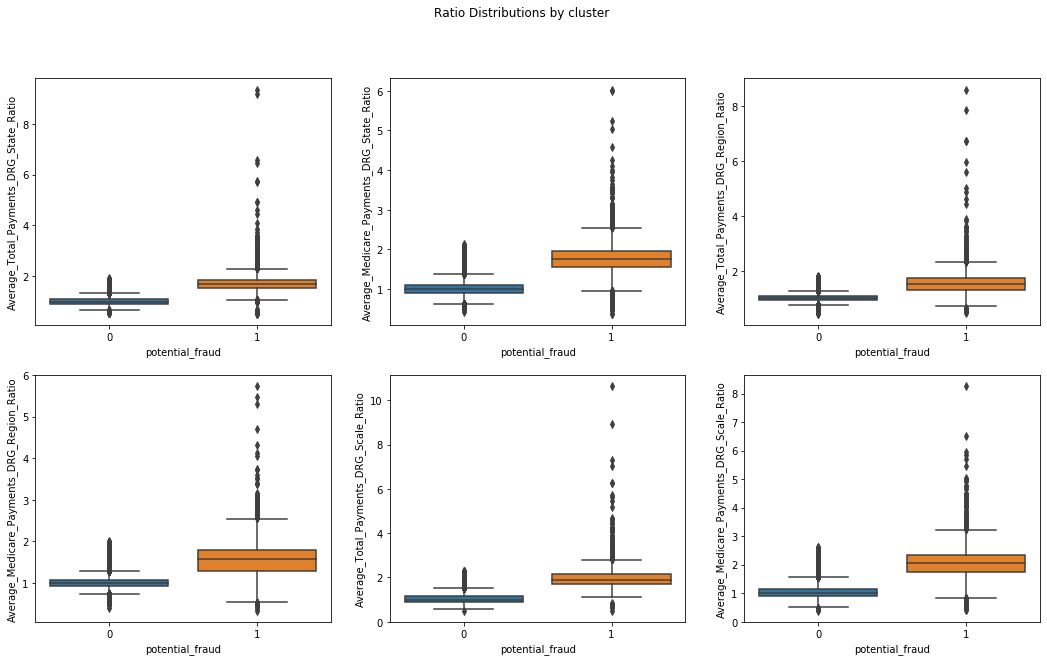

In [155]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Ratio Distributions by cluster')
sns.boxplot(ax=axes[0, 0],x="potential_fraud", y="Average_Total_Payments_DRG_State_Ratio", data=combined_result)
sns.boxplot(ax=axes[0, 1],x="potential_fraud", y="Average_Medicare_Payments_DRG_State_Ratio", data=combined_result)
sns.boxplot(ax=axes[0, 2],x="potential_fraud", y="Average_Total_Payments_DRG_Region_Ratio", data=combined_result)
sns.boxplot(ax=axes[1, 0],x="potential_fraud", y="Average_Medicare_Payments_DRG_Region_Ratio", data=combined_result)
sns.boxplot(ax=axes[1, 1],x="potential_fraud", y="Average_Total_Payments_DRG_Scale_Ratio", data=combined_result)
sns.boxplot(ax=axes[1, 2],x="potential_fraud", y="Average_Medicare_Payments_DRG_Scale_Ratio", data=combined_result)

As shown in the above boxplot, potential_fraud group has significantly higher ratios in all 6 features compared with non-fraud, which means the potential_fraud group does show a trend of overcharging compared with the rest. Also, it accounts for 2.98% of all observations, which  is a reasonable size. Therefore, I identify the observations that are considered as cluster 1 by both knn and pca methods as anomalies.

### Which hospitals can be identified as potential fraud? <a class="anchor" id="2.5"></a>

In [191]:
#percentage of DRGs that are identified as fraud
fraud_percent=(combined_result.groupby(['Name'])['potential_fraud'].sum()*100/combined_result.groupby(['Name'])['potential_fraud'].count()).reset_index()
fraud_count=combined_result.groupby(['Name'])['potential_fraud'].sum().reset_index()
fraud_by_id=pd.merge(fraud_count,fraud_percent,how='left',on='Name')
fraud_by_id.columns=['Name','fraud_count','fraud_percent']
fraud_by_id.sort_values(by=['fraud_count','fraud_percent'],ascending=False).head(30)

,Name,fraud_count,fraud_percent
1195,JACKSON MEMORIAL HOSPITAL,94,100.000000
2913,UCSF MEDICAL CENTER,79,98.750000
34,ALBERT EINSTEIN MEDICAL CENTER,79,91.860465
1235,"JOHNS HOPKINS HOSPITAL, THE",78,82.978723
2730,STANFORD HOSPITAL,77,88.505747
2800,TEMPLE UNIVERSITY HOSPITAL,70,97.222222
2979,UNIVERSITY OF TEXAS MEDICAL BRANCH GAL,68,98.550725
3111,WESTCHESTER MEDICAL CENTER,68,90.666667
2966,UNIVERSITY OF ILLINOIS HOSPITAL,61,98.387097
1047,HENNEPIN COUNTY MEDICAL CENTER,61,89.705882


By ranking the hospitals by both the number of DRGs identified as potential fraud and percentage of DRGs identified as potential fraud, I get the top 30 hospitals that have both high number of DRGs and high percentage of DRGs identified as potential fraud. These hospitals definitely deserve more close examination.

In [195]:
# Where are these hospitals?
top_fraud_hospital=fraud_by_id.sort_values(by=['fraud_count','fraud_percent'],ascending=False).head(200)
top_fraud_hospital=pd.merge(top_fraud_hospital,df9,how='left',on='Name')
top_fraud_hospital=top_fraud_hospital.drop_duplicates(subset=['Name'])
print(top_fraud_hospital.State.value_counts().head(10))

CA    37
NY    35
MD    14
PA    11
IL    11
FL     9
TX     8
OH     7
AZ     5
MI     5
Name: State, dtype: int64


Hospitals identified as potential fraud are more concentrated in CA, NY, MD, PA and IL.